In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial as spatial
import sys
import torch
import torch.nn as nn
import torch.optim as optim


## class: PointData Loader & fun: drawPoint

In [322]:
class PointData:
    def __init__(self,path:str,seed=1145141919):
        self.path = path
        self.pData=np.loadtxt(self.path).astype('float32')
        sys.setrecursionlimit(int(max(1000, round(
          self.pData.shape[0] /
          10))))
        self.kdtree=spatial.cKDTree(self.pData,10)
        self.patch=[]
        self.radScale=-1
        self.rad=-1
        self.rng=np.random.RandomState(seed)
        print("Load %s success!"%(self.path))
    def getPatch(self,center,rad:float):
        return self.pData[np.array(self.kdtree.query_ball_point(center, rad))]
    def gernatePatch(self,rad:float,point_per_patch=100):
        if self.radScale<0:
            pData_g=torch.from_numpy(self.pData).to(device)
            pmin=np.array([torch.min(pData_g[:,i]).cpu() for i in range(3)])
            pmax=np.array([torch.max(pData_g[:,i]).cpu() for i in range(3)])
            self.radScale = np.linalg.norm(pmin - pmax)
        if self.rad==rad*self.radScale:
            print("Patch already exists!")
            return
        else:
            print(self.rad, rad * self.radScale)
        self.patch=[]
        self.rad = rad * self.radScale

        total_range=self.pData.shape[0]
        for i in range(total_range):
            p=self.pData[i]
            patch_=self.getPatch(p, self.rad)
            if patch_.shape[0]>point_per_patch:
                patch_ind = self.rng.choice(patch_.shape[0],
                                         point_per_patch,
                                         replace=False)
                patch_=patch_[patch_ind]
            if patch_.shape[0]<point_per_patch:
                patch_ = np.vstack(
                    (patch_,
                     np.array([[0] * 3] *
                              (point_per_patch - patch_.shape[0]))))
            self.patch.append(patch_)
            if i%100==99:
                print("[Build patch %d%%] shape %s"%(round(100*i/total_range),self.path),end='\r')
        self.patch=np.array(self.patch)
        print("\nBuild patch set success!")


device = torch.device("cuda")

def lossMin(pd,pOrg,scale=1000):
    p1=torch.from_numpy(pd).to(device)
    po=torch.from_numpy(pOrg).to(device)
    # print(p1.shape,po.shape)

    # return np.array([(torch.min((p - po).pow(2).sum(1))*scale).cpu().numpy() for p in p1])
    res=torch.zeros(p1.shape[0],dtype=torch.float,device=device)
    for i in range(p1.shape[0]):
        res[i]=torch.min((p1[i] - po).pow(2).sum(1))
    return res.cpu().numpy() * scale



def drawPoint(fig,ax,pDataPre,pDataOrg,loss=lossMin,lossScale=1000,pointSize=5,elev=90,azim=-90,pltShow=True,hideGrid=True):
    l = loss(pDataPre, pDataOrg, lossScale)
    x=pDataPre[:,0].reshape(-1,)
    y=pDataPre[:,1].reshape(-1,)
    z=pDataPre[:,2].reshape(-1,)
    print("Compute loss success!")

    # colorbar
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    my_cmap = plt.get_cmap('jet')

    pos=ax.scatter3D(x,y,z,s=pointSize,c=l,cmap=my_cmap, vmin=0, vmax=1)
    # fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=my_cmap), ax=ax)
    if hideGrid:
        plt.axis('off')
        ax.grid(False)
        # ax.set_aspect("equal") 
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
    ax.view_init(elev=elev,azim=azim)
    if pltShow==True:
        plt.show()


In [307]:
# test=PointData("./pointCleanNetDataset/bunny100k.xyz") 
# test.getPatch(test.pData[0],0.015)

# pNoise=PointData("./pointCleanNetDataset/bunny100k_noise_white_1.00e-02.xyz")
# pNoise.gernatePatch(0.02)
# pNoise.patch[:3]
test=PointData("./pointCleanNetDataset/Cup33100k.xyz") 
test.getPatch(test.pData[0],0.015)

pNoise=PointData("./pointCleanNetDataset/Cup33100k_noise_white_1.00e-02.xyz")
pNoise.gernatePatch(0.03)
pNoise.patch[:3]

Load ./pointCleanNetDataset/Cup33100k.xyz success!
Load ./pointCleanNetDataset/Cup33100k_noise_white_1.00e-02.xyz success!
-1 0.08059923648834229
[Build patch 100%] shape ./pointCleanNetDataset/Cup33100k_noise_white_1.00e-02.xyz
Build patch set success!


array([[[-0.46336499, -0.49803099,  0.408788  ],
        [-0.50199097, -0.394375  ,  0.37244001],
        [-0.421655  , -0.43977001,  0.42194399],
        [-0.47315001, -0.409367  ,  0.453444  ],
        [-0.44448999, -0.50801498,  0.37697801],
        [-0.50915998, -0.434879  ,  0.328785  ],
        [-0.47277099, -0.51110399,  0.41600701],
        [-0.486314  , -0.470166  ,  0.33691901],
        [-0.43532899, -0.50944799,  0.393682  ],
        [-0.447671  , -0.459057  ,  0.42833999],
        [-0.48555499, -0.50439602,  0.41932201],
        [-0.46008199, -0.452149  ,  0.385263  ],
        [-0.52195799, -0.429766  ,  0.40875101],
        [-0.46590301, -0.492201  ,  0.399497  ],
        [-0.444774  , -0.43520799,  0.39623299],
        [-0.42666101, -0.439024  ,  0.41246501],
        [-0.484945  , -0.416439  ,  0.417633  ],
        [-0.446026  , -0.50909698,  0.42591599],
        [-0.468793  , -0.487257  ,  0.414318  ],
        [-0.48658299, -0.44867   ,  0.39721099],
        [-0.42601499

### Test

Compute loss success!


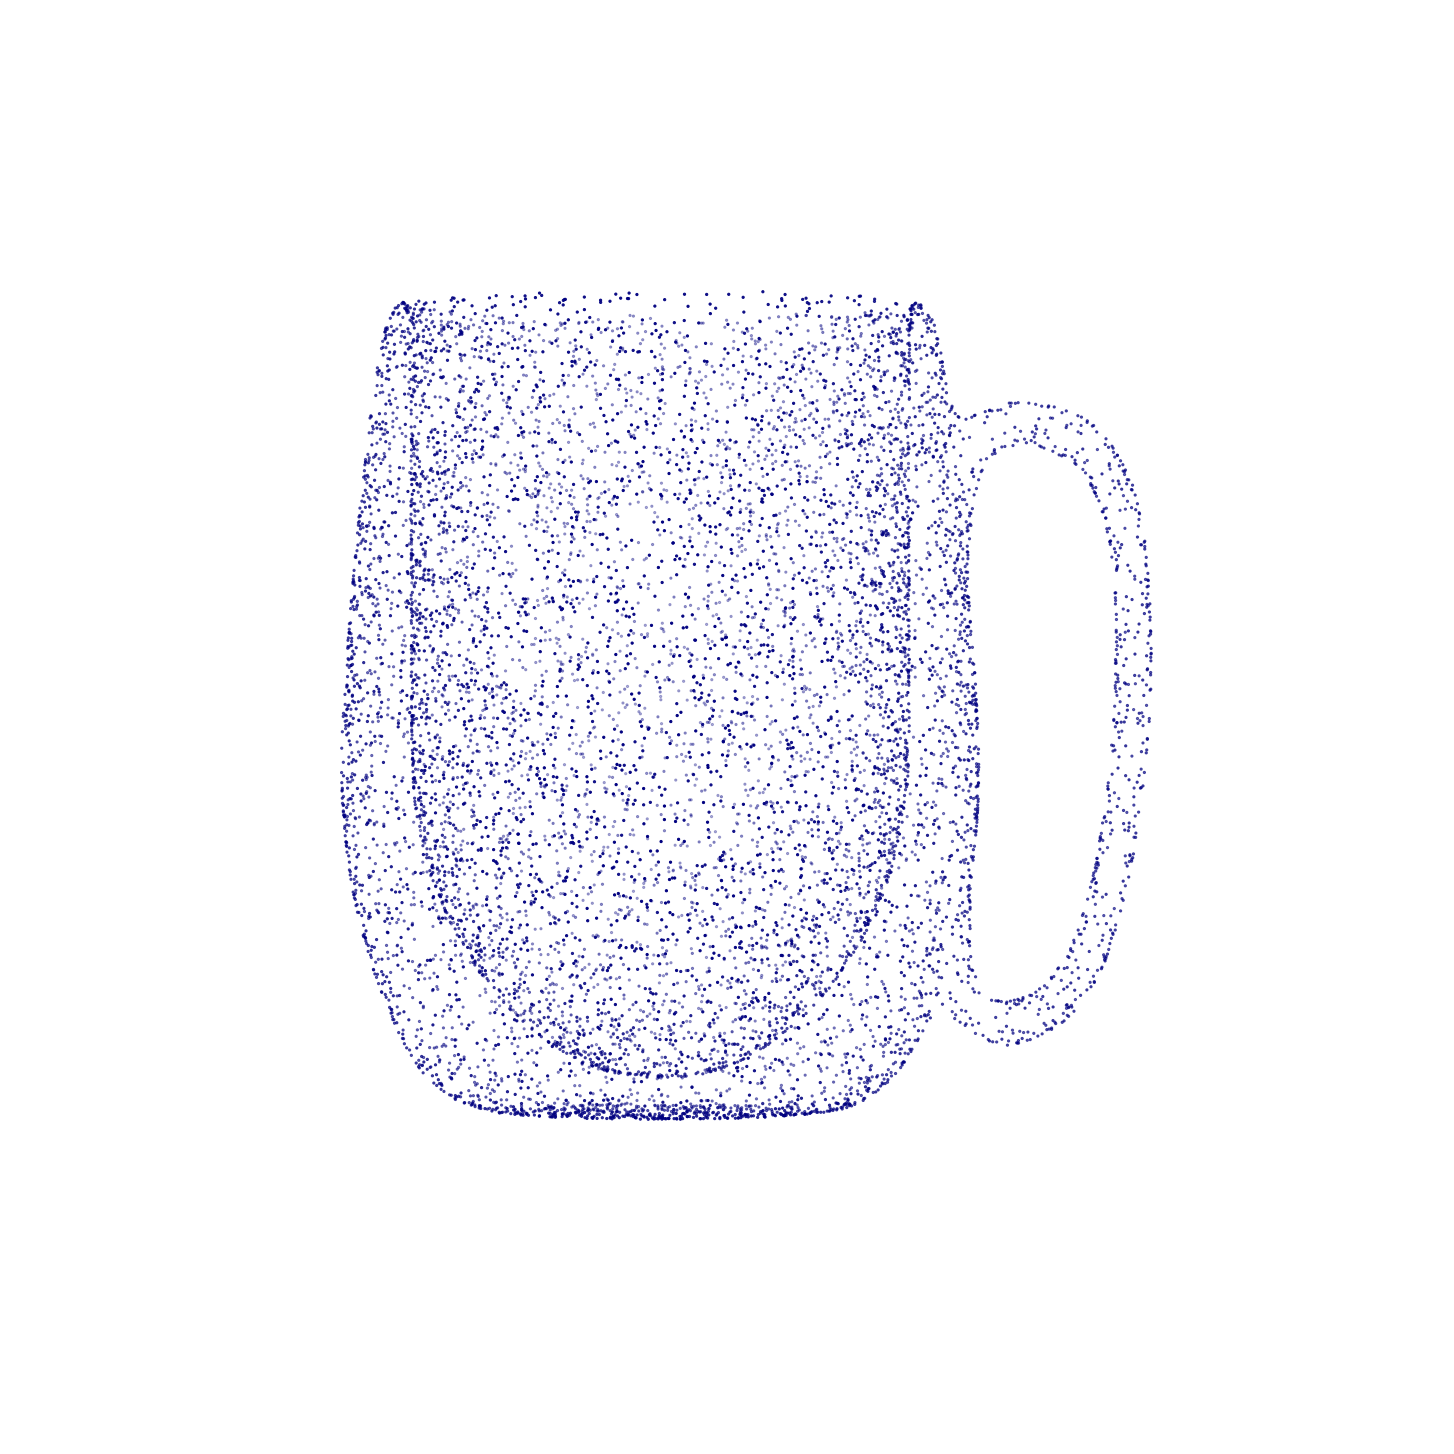

In [323]:
# 3D-scatter test
fig1 = plt.figure(figsize=(20, 20))
ax1 = Axes3D(fig1)

drawPoint(fig1,
          ax1,
          test.pData[:10000],
          test.pData[:10000],
          lossScale=1e4,
          pointSize=5)


torch.Size([100000, 3]) torch.Size([100000, 3])
[2.0571032 2.0626585 1.0963472 1.6209017 2.7208848 8.49106   3.8582447
 1.0158448 0.8760814 8.005444 ]


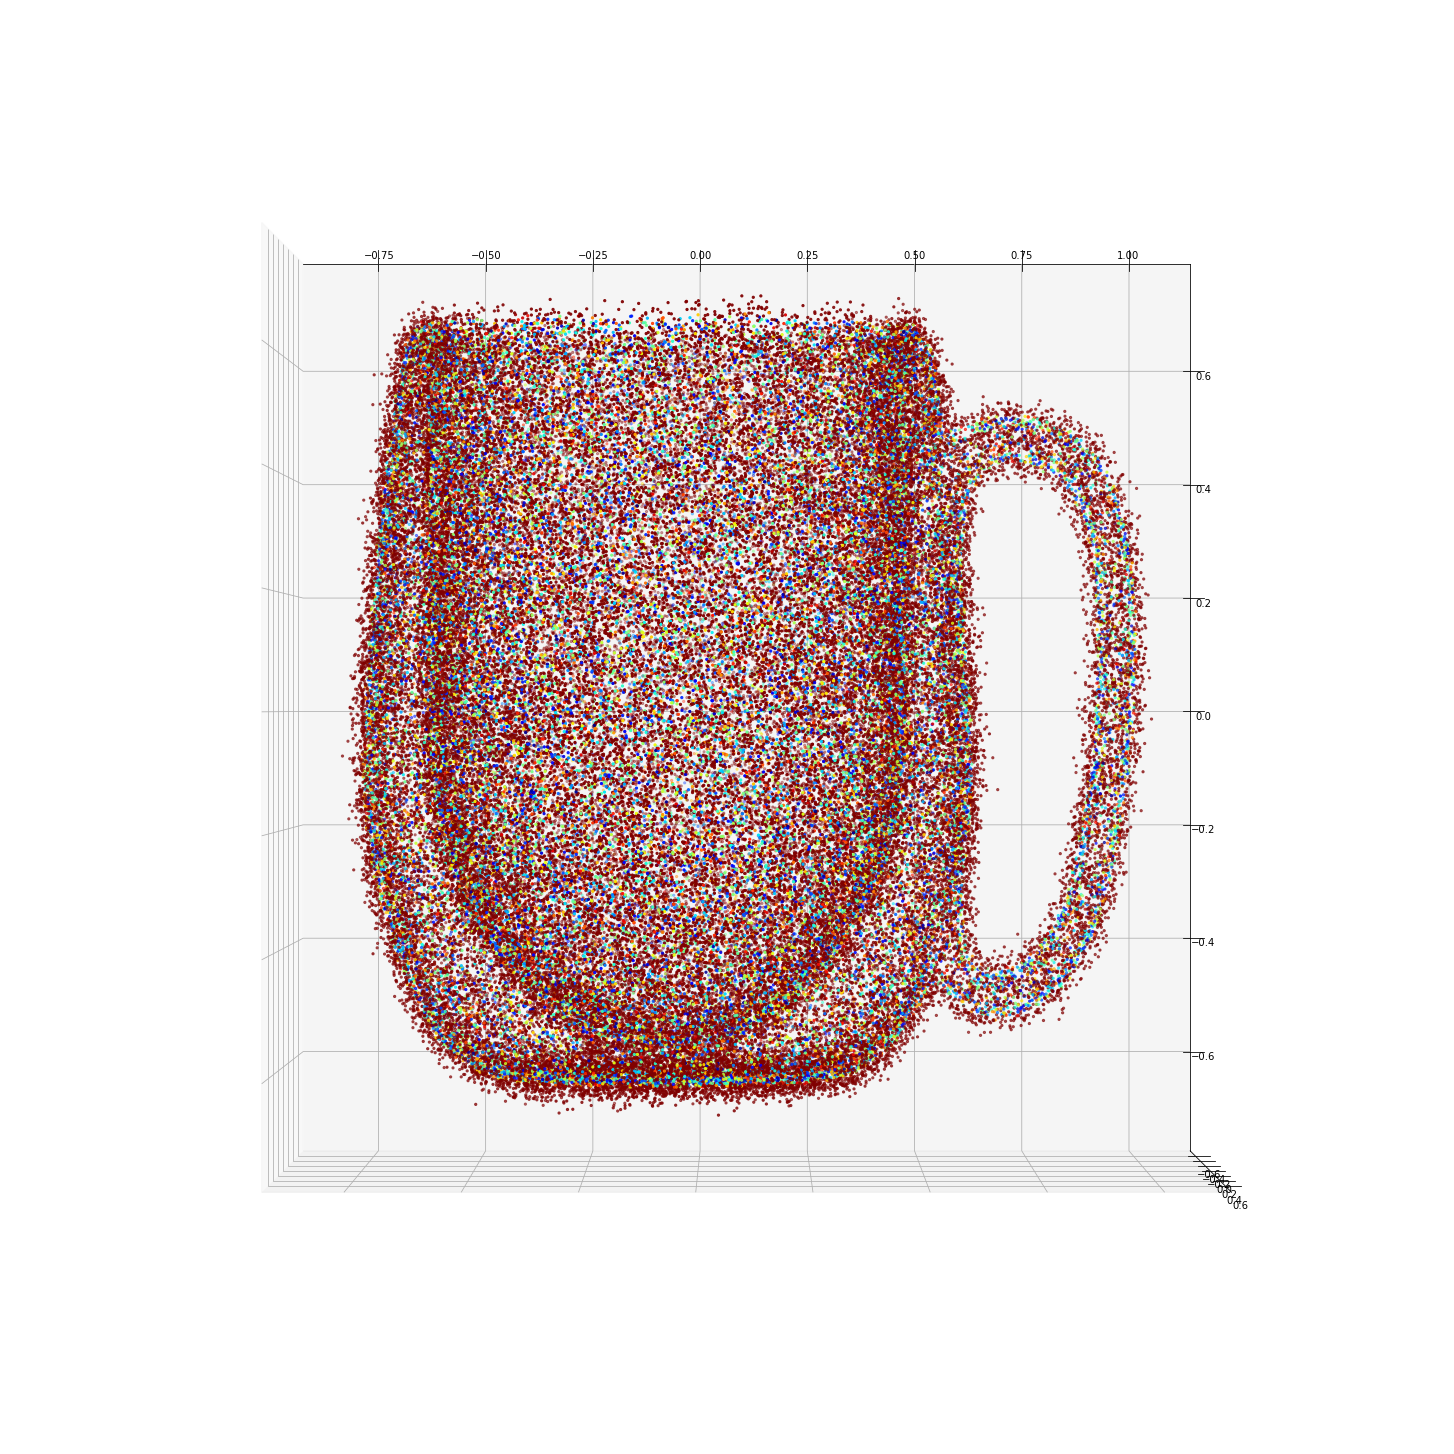

In [268]:
fig2 = plt.figure(figsize=(20, 20))
ax2 = Axes3D(fig2)
drawPoint(fig2, ax2, pNoise.pData, test.pData, lossScale=1e4, pointSize=5)


[[-0.50054598 -0.47530499  0.35667601]
 [-0.50833702 -0.47578701  0.36024201]
 [-0.50596702 -0.459979    0.36301699]
 ...
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
torch.Size([10000, 3]) torch.Size([100000, 3])
[0.29235741 1.0005565  0.11157961 0.49434158 2.1471145  1.4902914
 1.7515702  2.742961   3.6461246  3.774802  ]


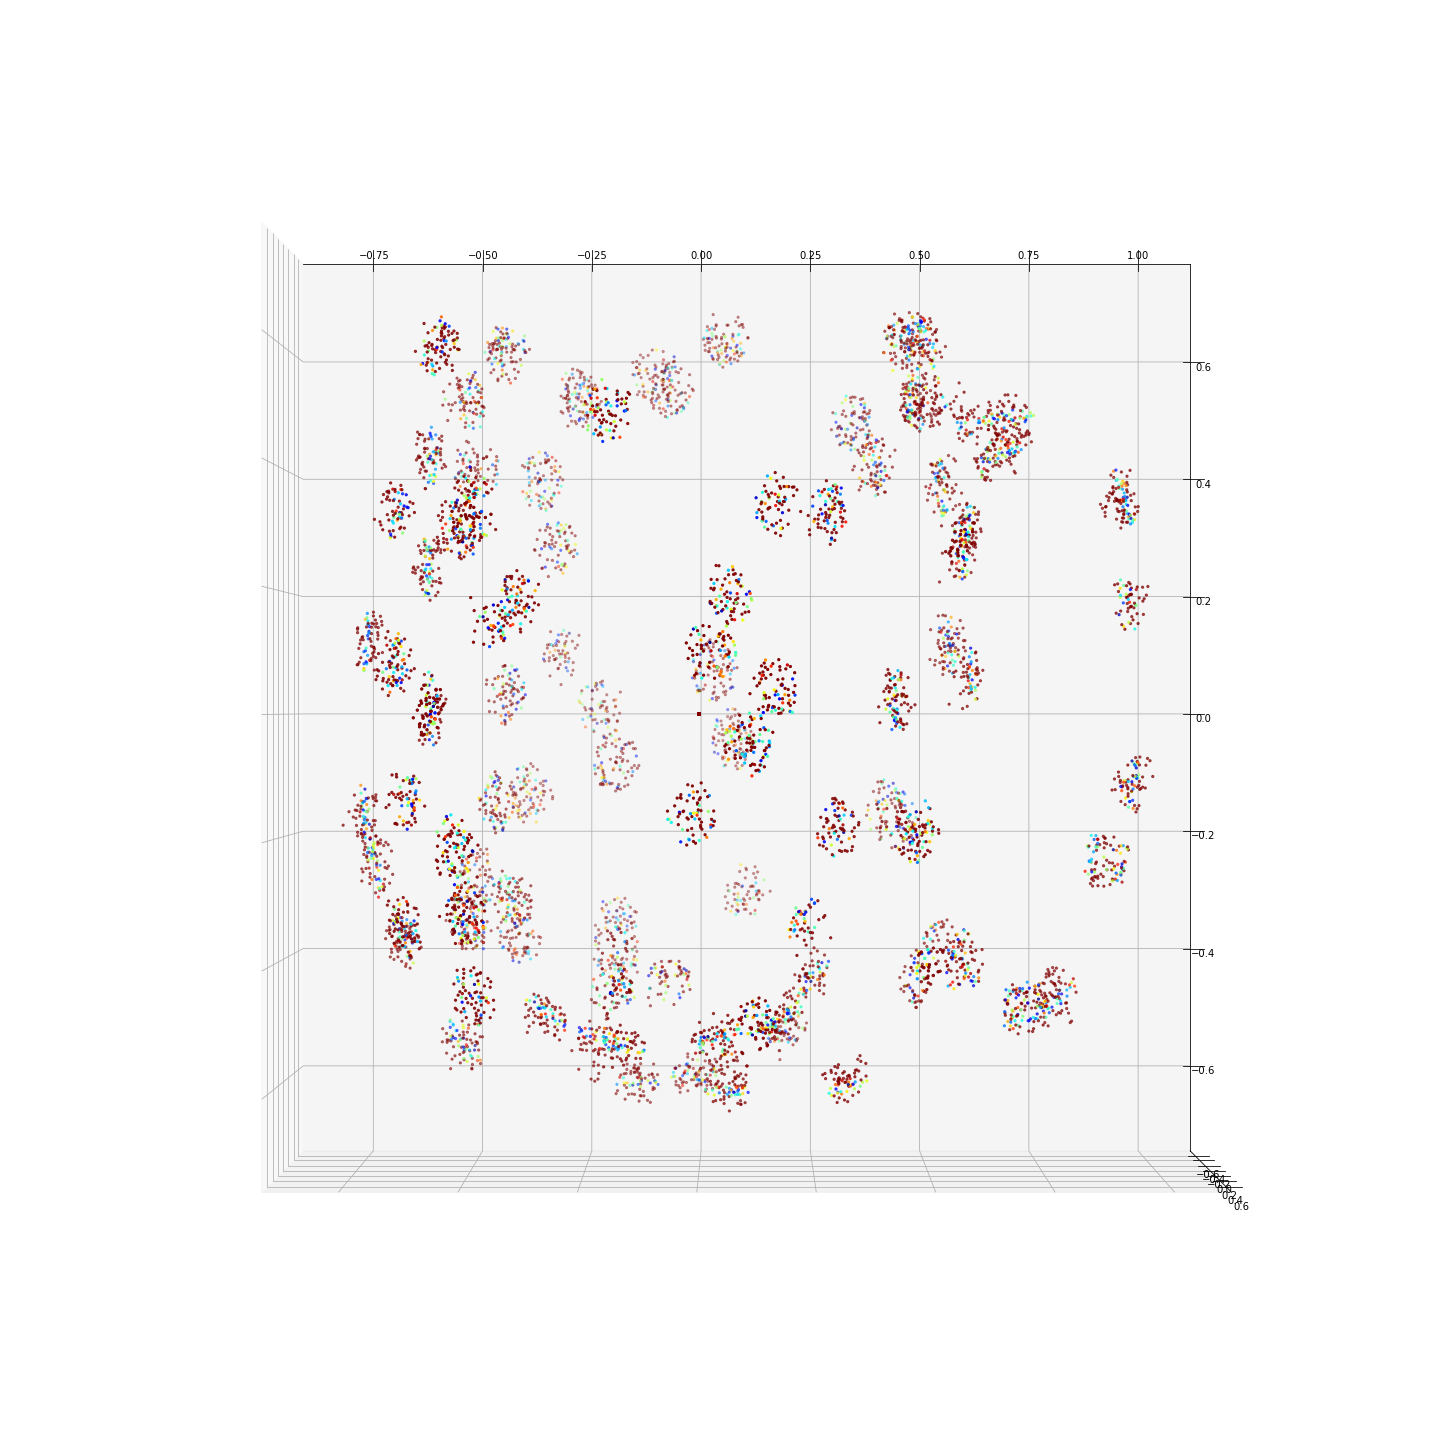

In [269]:
fig3 = plt.figure(figsize=(20, 20))
ax3 = Axes3D(fig3)
patdata=[]
for pa in pNoise.patch[:100]:
    for p in pa:
        patdata.append(p)

patdata=np.array(patdata)
print(patdata)

drawPoint(fig3, ax3, patdata, test.pData, lossScale=1e4, pointSize=5)


## Gauss filter


In [192]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class GaussFilter(nn.Module):
    def __init__(self,kernelRad):
        super().__init__()
        self.kernelRad = kernelRad
    def forward(self,patch,pData):
        pData=pData.unsqueeze(1)
        vDis=patch-pData
        nDis=torch.norm(vDis,dim=2)/self.kernelRad
        weight=0.39894228040143267794*torch.exp(-nDis**2/2.)
        we_sum=weight.sum(1).unsqueeze(1)
        weight=weight/we_sum
        weight=weight.unsqueeze(2)
        WdPatp=weight*patch
        res=WdPatp.sum(1)
        # for i in range(pData.shape[0]):
        #   pData[i]=(gaussKernel((patch[i]-pData[i]).))
        return res


In [277]:
patch_g = torch.from_numpy(pNoise.patch).to(device)
pData_g = torch.from_numpy(pNoise.pData).to(device)
print(patch_g.shape,pData_g.shape,pData_g.unsqueeze(1).shape)

torch.Size([100000, 100, 3]) torch.Size([100000, 3]) torch.Size([100000, 1, 3])


In [278]:
gf = GaussFilter(pNoise.rad)
with torch.no_grad():
    prev=gf(patch_g,pData_g)
print(prev[:10], prev.shape, pNoise.rad)
print(pData_g[:10])


tensor([[-0.4784, -0.4541,  0.3976],
        [ 0.5794,  0.2812, -0.0767],
        [-0.7252,  0.1160,  0.0148],
        [ 0.7089, -0.4702,  0.0537],
        [ 0.5363,  0.3792, -0.1880],
        [ 0.4940,  0.5169,  0.0112],
        [-0.3134,  0.2798, -0.4696],
        [-0.1904,  0.4795,  0.5117],
        [ 0.4181, -0.1551, -0.4571],
        [ 0.1924, -0.5285, -0.4610]], device='cuda:0', dtype=torch.float64) torch.Size([100000, 3]) 0.08059923648834229
tensor([[-0.4775, -0.4441,  0.3905],
        [ 0.5892,  0.2742, -0.0797],
        [-0.7176,  0.1188,  0.0153],
        [ 0.7110, -0.4807,  0.0657],
        [ 0.5465,  0.3783, -0.1940],
        [ 0.4887,  0.5074,  0.0074],
        [-0.3277,  0.2806, -0.4789],
        [-0.1896,  0.4807,  0.5010],
        [ 0.4124, -0.1594, -0.4581],
        [ 0.2004, -0.5461, -0.4785]], device='cuda:0')


In [279]:
pre_pNoise=prev.cpu().numpy()

torch.Size([100000, 3]) torch.Size([100000, 3])
[ 0.17711334  0.3876541   0.09232868  7.5652933   0.6005308  12.661783
  0.22903752  0.34098095  0.67362356  0.05587933]


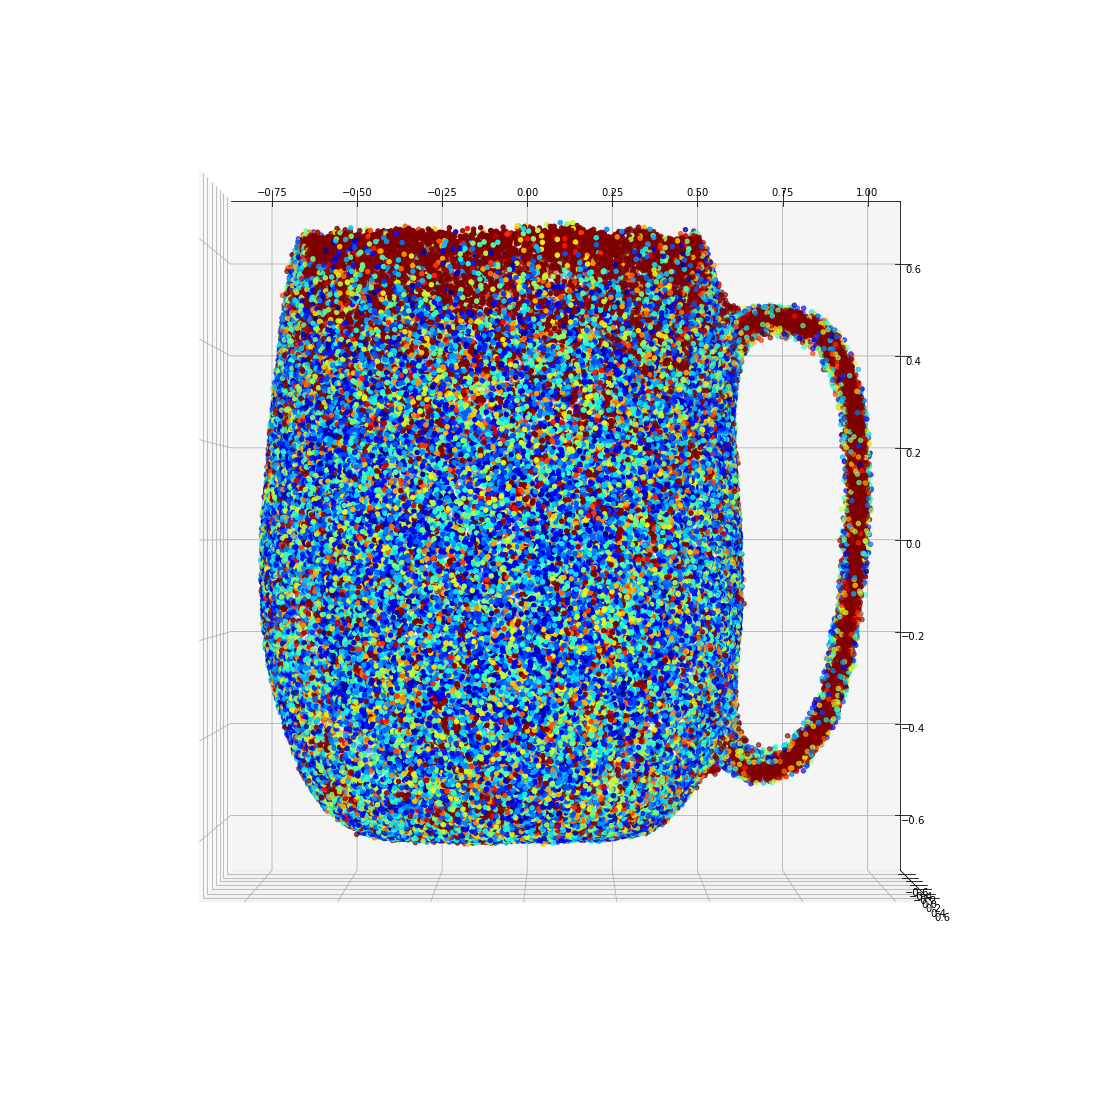

In [280]:
fig4 = plt.figure(figsize=(20, 20))
# ax4 = Axes3D(fig4)
ax4 = fig4.add_subplot(1, 1, 1, projection='3d')
drawPoint(fig4, ax4, pre_pNoise, test.pData, lossScale=1e4, pointSize=20)

In [331]:
def pkg_denoise_gauss(fig,noiseSet,orgSet,rad=0.02, lossScale=1e4, pointSize=8,subIndex=0,lineNum=1):
    noiseSet.gernatePatch(rad)
    patch_g = torch.from_numpy(noiseSet.patch).to(device)
    pData_g = torch.from_numpy(noiseSet.pData).to(device)
    print("Copy data to gpu success!")

    gf = GaussFilter(noiseSet.rad)
    with torch.no_grad():
        prev=gf(patch_g,pData_g)

    print("Finish denoise!")
    pre_pNoise=prev.cpu().numpy()

    print("Drawing Picture original point...")

    ax1 = fig.add_subplot(lineNum, 3, 1+subIndex*2, projection='3d')
    drawPoint(fig, ax1, orgSet.pData, orgSet.pData, lossScale=lossScale, pointSize=pointSize,pltShow=False)

    print("Drawing Picture noise point...")

    ax2 = fig.add_subplot(lineNum, 3, 2+subIndex*2, projection='3d')
    drawPoint(fig, ax2, noiseSet.pData, orgSet.pData, lossScale=lossScale, pointSize=pointSize,pltShow=False)

    print("Drawing Picture denoise result...")
    ax3 = fig.add_subplot(lineNum, 3, 3+subIndex*2, projection='3d')
    drawPoint(fig, ax3, pre_pNoise, orgSet.pData, lossScale=lossScale, pointSize=pointSize,pltShow=False)


Patch already exists!
Copy data to gpu success!
Finish denoise!
Drawing Picture original point...
Compute loss success!
Drawing Picture noise point...
Compute loss success!
Drawing Picture denoise result...
Compute loss success!


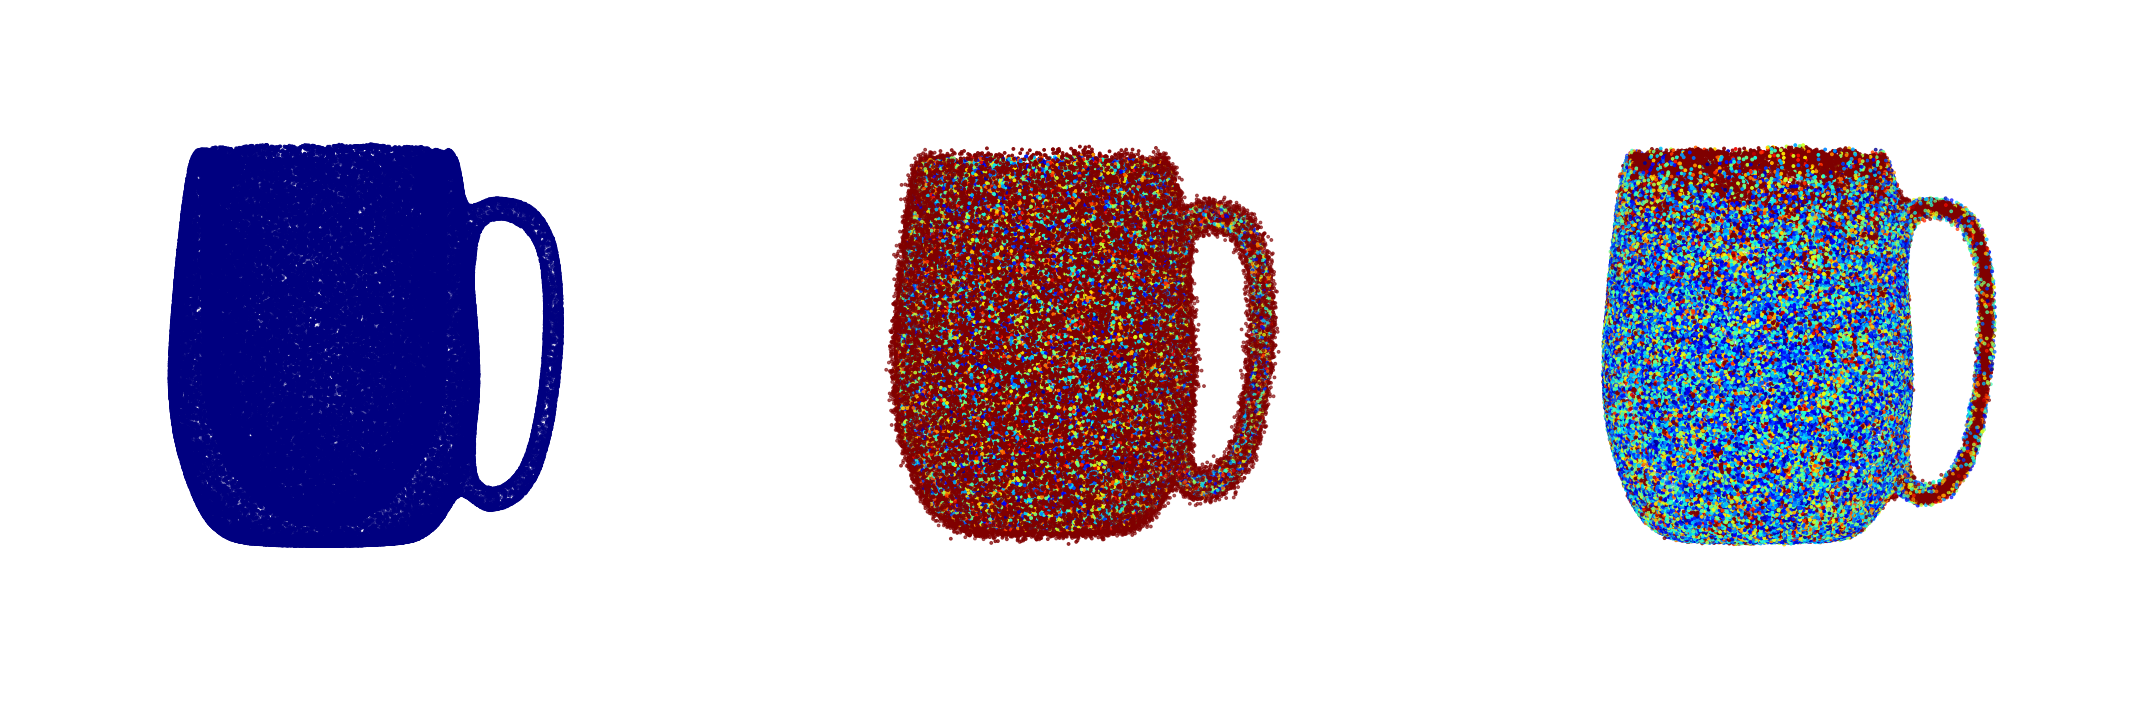

In [333]:
fig=plt.figure(figsize=(30, 10))
pkg_denoise_gauss(fig,pNoise,test,rad=0.03)

plt.tight_layout()
plt.show()